# System versions

- cuda 12
    1. Install appropriate cupy version matching with cuda
        - pip install cupy-cuda12x
    3. On CUDA 12.2 or later, CUDA Runtime header files are required to compile kernels in CuPy
        - pip install "nvidia-cuda-runtime-cu12==12.6.*"

In [1]:
is_use_source = True

if is_use_source:
    import os
    os.environ["boostrsa_isRunSource"] = "True"
    os.environ["boostrsa_source_home"] = "/home/seojin/boostrsa/src/boostrsa"

# Common Library

In [2]:
import os
import sys
import numpy as np 
from scipy.stats import gamma
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import nibabel as nb
from collections import Counter
from copy import copy
from nilearn.plotting import plot_design_matrix
from sklearn.linear_model import LinearRegression
from itertools import product

# rsatoolbox
from rsatoolbox.data.noise import prec_from_residuals
from rsatoolbox.util.searchlight import get_volume_searchlight
from rsatoolbox.data.dataset import Dataset
from rsatoolbox.rdm import calc_rdm, concat

# boostrsa
is_use_source = True
    
if os.getenv("boostrsa_isRunSource"):
    sys.path.append("../src/boostrsa")
    from boostrsa_types import ShrinkageMethod
    from searchlight import calc_sl_precisions, calc_sl_rdm_crossnobises
else:
    from boostrsa.boostrsa_types import ShrinkageMethod
    from boostrsa.searchlight import calc_sl_precisions, calc_sl_rdm_crossnobises

In [3]:
from numba import cuda
cuda.select_device(0)
device = cuda.get_current_device()
print("GPU: ", device)

GPU:  <CUDA device 0 'b'NVIDIA GeForce RTX 3090''>


# Configuration

In [4]:
# Set your cuda path 
os.environ["CUDA_HOME"] = "/usr/local/cuda-12.6" # for linux

# Parameters

In [5]:
# Save directory
save_dir_path = "/mnt/ext1/seojin/temp"
is_use_fullMask = False
data_type = np.float64

## Simulation parameters

In [6]:
if is_use_fullMask:
    mask = nb.load(os.path.join("..", "data", "full_mask.nii.gz"))
    brain_shape = mask.shape
    nx, ny, nz = brain_shape
    affine = mask.affine
    mask = mask.get_fdata()
else:
    # Brain
    brain_shape = (10, 10, 10)
    nx, ny, nz = brain_shape
    
    # Mask of brain
    mask = np.zeros(brain_shape).astype(np.uint8)
    mask[5:15, 5:15, 5:15] = 1
    
    # Create an affine transformation matrix (2mm isotropic voxels, no rotation)
    affine = np.diag([2, 2, 2, 1])

# Simulation experiment parameters
n_timepoints = 300  # total time points
stimuli_types = {
    "ISI" : 0,
    "stim1" : 1,
    "stim2" : 2,
    "stim3" : 3,
    "stim4" : 4,
}
stimuli_withISI = np.array(list(stimuli_types.keys()))
stimuli = stimuli_withISI[stimuli_withISI != "ISI"]

response_duration = 10  # duration of response in timepoints
n_run = 2

# HRF Parameters
hrf_times = np.arange(0, 30, 1)  # 30 time points for the HRF
peak = 6
undershoot = 12
ratio = 0.35
hrf = gamma.pdf(hrf_times, peak) - ratio * gamma.pdf(hrf_times, undershoot)

# Response parameter
response_amplitudes = {
    "ISI" : (np.zeros(brain_shape)),
    "stim1" : (np.random.random(brain_shape) * 8),
    "stim2" : (np.random.random(brain_shape) * 4),
    "stim3" : (np.random.random(brain_shape) * 2),
    "stim4" : (np.random.random(brain_shape)),
}

# Generate datas

## Simulate experiment

In [7]:
stimulus_timings_perRun = []
for run_i in range(n_run):
    stimulus_timings = np.zeros(n_timepoints)
    
    sudo_random_stim = list(stimuli)
    
    current_time = 0
    while current_time < n_timepoints:
        stimulus = np.random.choice(sudo_random_stim)
        onset = current_time
        duration = response_duration
        offset = min(current_time + duration, n_timepoints)

        # Simulate response
        stimulus_timings[onset:offset] += stimuli_types[stimulus]

        # Add inter stimulus interval
        isi = np.random.randint(5, 15)
        current_time += duration + isi
        
        sudo_random_stim.remove(stimulus)
        if len(sudo_random_stim) == 0:
            sudo_random_stim = list(stimuli)
            
    run_stim_df = pd.get_dummies(stimulus_timings.astype(np.uint8))
    run_stim_df.columns = stimuli_withISI
    run_stim_df = run_stim_df.astype(np.uint8)
    stimulus_timings_perRun.append(run_stim_df)

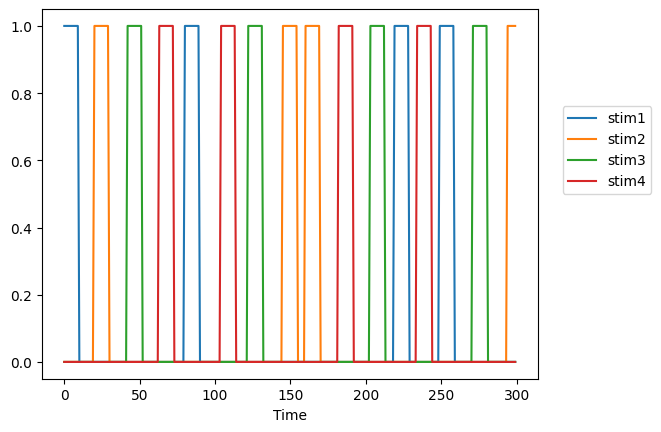

In [8]:
run_i = 0
for stim in stimuli:
    plt.plot(stimulus_timings_perRun[run_i][stim], label = stim)

plt.xlabel("Time")
plt.legend(loc = (1.05, 0.5))

## Simulate brain response

In [9]:
# stimulate reference brain response in correspond to stimulus
reference_brain_response_perRun = copy(stimulus_timings_perRun)
for run_i in range(n_run):
    for stim in stimuli_types:
        reference_brain_response_perRun[run_i][stim] = np.convolve(reference_brain_response_perRun[run_i][stim], hrf, mode = "full")[:n_timepoints]

In [10]:
# population beta 
population_betas = np.array([response_amplitudes[stim] for stim in stimuli_withISI])
population_betas = population_betas.reshape(len(stimuli_withISI), -1)

In [11]:
# Mask
mask_3d_indexes = np.array(np.where(mask == 1))
mask_1d_indexes = np.ravel_multi_index(mask_3d_indexes, (nx, ny, nz))

In [12]:
noise_level = 2

fmri_data = np.zeros((n_run, n_timepoints, nx, ny, nz))
for run_i in range(n_run):
    reference_activation = reference_brain_response_perRun[run_i].to_numpy()
    
    # population response
    response = (reference_activation @ population_betas)
    
    # noise
    noise = np.random.normal(0, noise_level * (run_i+1), n_timepoints) # Add Gaussian noise
    noise = noise.reshape(n_timepoints, 1)
    
    response_with_noise = response + noise
    
    # brain response
    fmri_data[run_i, :, :, :] = (response_with_noise).reshape(n_timepoints, nx, ny, nz)
mask_fmri = np.expand_dims(np.expand_dims(mask, 0), 0)
fmri_data = fmri_data[:, :] * mask

# Get beta values & residuals

In [13]:
design_mats = copy(reference_brain_response_perRun)

<Axes: label='conditions', ylabel='scan number'>

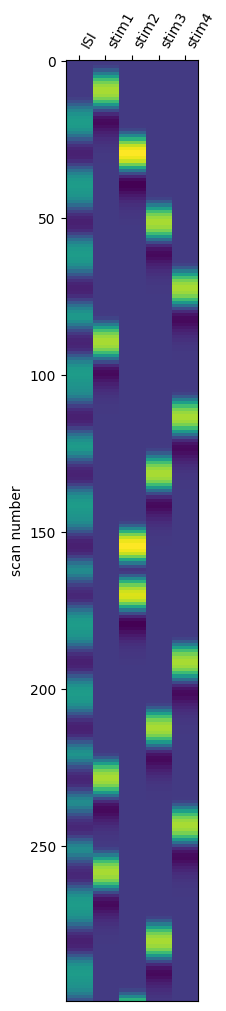

In [14]:
plot_design_matrix(design_mats[0]) # *bias is automatically included in linear regression model

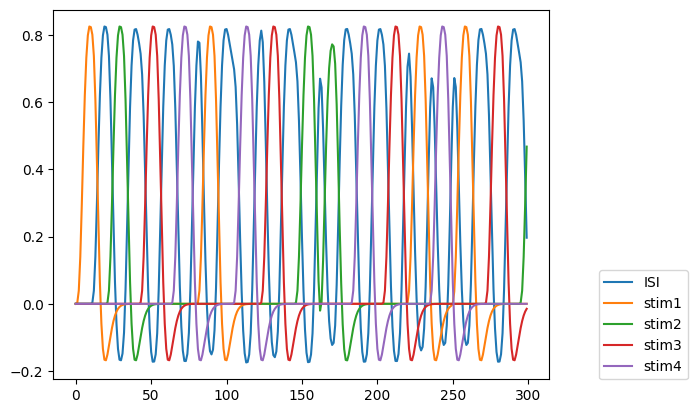

In [15]:
run_i = 0 

plt.plot(design_mats[run_i])
plt.legend(design_mats[run_i].columns, loc = (1.1, 0))

In [16]:
# run, time, nx, ny, nz -> run, nx, ny, nz, time
fmri_data = fmri_data.transpose(0, 2, 3, 4, 1)

In [17]:
model = LinearRegression()

coefficients = np.zeros((n_run, nx, ny, nz, len(stimuli_withISI)))
intercepts = np.zeros((n_run, nx, ny, nz))
residuals = np.zeros(fmri_data.shape)

In [18]:
for run_i in tqdm(range(n_run)):
    design_mat = design_mats[run_i]
    
    for j in range(len(mask_3d_indexes[1])):
        # Linear regression
        x,y,z = mask_3d_indexes[:, j]
        target = fmri_data[run_i, x,y,z, :]
        model.fit(design_mat, target)
        
        # Intercept
        intercepts[run_i, x,y,z] = model.intercept_
        
        # Coef
        coefficients[run_i, x,y,z, :] = model.coef_
        
        # Residual
        residual = target - model.predict(design_mat)
        residuals[run_i, x,y,z, :] = residual

100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


# Make appropriate format

Following values' shapes must be matched.

- beta
    - shape: (a number of condition, a number of target voxel)
- residual
    - shape: (a number of session, a number of times on a session, a number of target voxel)
- condition
    - shape (a number of condition)
- session
    - shape: (a number of condition)

In [19]:
betas = coefficients[:, :, :, :, ["stim" in e for e in np.array(stimuli_withISI)]]
betas = betas[:, mask_3d_indexes[0, :], mask_3d_indexes[1, :], mask_3d_indexes[2, :], :]
betas = np.concatenate([beta_perRun for beta_perRun in betas], axis = 1)
betas = betas.transpose(1, 0)

In [20]:
residuals = residuals[:, mask_3d_indexes[0, :], mask_3d_indexes[1, :], mask_3d_indexes[2, :], :]
residuals = residuals.transpose(0, 2, 1)
residual_types = np.arange(1, residuals.shape[0] + 1)

In [21]:
stimuli = np.array(stimuli)
target_stimuli = stimuli[["stim" in e for e in stimuli]]
conditions = np.concatenate([target_stimuli for _ in range(n_run)])

In [22]:
sessions = []
for run_index in range(n_run):
    run_number = run_index + 1
    sessions += [np.repeat(run_number, len(target_stimuli))]
sessions = np.concatenate(sessions)

In [23]:
print("beta shape:", betas.shape)
print("residual shape:", residuals.shape)
print("condition shape:", conditions.shape)
print("session shape:", sessions.shape)

beta shape: (8, 125)
residual shape: (2, 300, 125)
condition shape: (8,)
session shape: (8,)


# Searchlight region

In [24]:
radius = 3
threshold = 1

centers, neighbors = get_volume_searchlight(mask, 
                                            radius=radius, 
                                            threshold=threshold)
uq_n_neighbors = np.unique([len(e) for e in neighbors])

Finding searchlights...: 100%|██████████| 125/125 [00:00<00:00, 12009.25it/s]

Found 27 searchlights


# Params for calculating precision matrix

In [25]:
shrinkage_method = ShrinkageMethod.shrinkage_eye

# Searchlight - CPU version

In [26]:
subj_number = 1

rdm_crossnobis_cpus = []
n_center = len(centers)
for i in tqdm(range(n_center)):
    center = centers[i]
    neighbor = neighbors[i]
    
    # Mask
    n_channel = betas.shape[1]
    mask_out = np.zeros(n_channel)
    for neighbor_pos in neighbor:
        for brain_i, brain_pos in enumerate(mask_1d_indexes):
            if brain_pos == neighbor_pos:
                mask_out[brain_i] = 1
    
    # Beta
    masked_betas = betas[:, mask_out == 1]
    
    # Residual
    masked_residuals = residuals[:, :, mask_out == 1]
    
    # Precision matrix
    noise_precision_mats = prec_from_residuals(masked_residuals, method = shrinkage_method)
    
    # Crossnobis
    measurements = masked_betas
    nVox = measurements.shape[-1]
    des = {'subj': subj_number, "voxel_index" : int(center) }
    obs_des = {'conds': conditions, 'sessions': sessions}
    chn_des = {'voxels': np.array(['voxel_' + str(x) for x in np.arange(nVox)])}

    dataset = Dataset(measurements = measurements,
                      descriptors = des,
                      obs_descriptors = obs_des,
                      channel_descriptors = chn_des)
    rdm_crossnobis = calc_rdm(dataset, 
                              descriptor = "conds", 
                              method = "crossnobis",
                              noise = noise_precision_mats,
                              cv_descriptor = "sessions")
    del rdm_crossnobis.descriptors["noise"]
    
    rdm_crossnobis_cpus.append(rdm_crossnobis)

rdm_crossnobis_cpus = concat(rdm_crossnobis_cpus)

  0%|          | 0/27 [00:00<?, ?it/s]/home/seojin/anaconda3/envs/recent/lib/python3.12/site-packages/numpy/_core/numeric.py:457: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')
100%|██████████| 27/27 [00:00<00:00, 116.46it/s]


# Searchlight - GPU version

In [27]:
n_split_data = 2048

In [28]:
calc_sl_precisions(centers = centers, 
                   neighbors = neighbors, 
                   residuals = residuals, 
                   prec_types = residual_types,
                   n_split_data = n_split_data, 
                   mask_1d_indexes = mask_1d_indexes, 
                   save_dir_path = save_dir_path,
                   shrinkage_method = shrinkage_method,
                   dtype = data_type)

  0%|          | 0/1 [00:00<?, ?it/s]/home/seojin/anaconda3/envs/recent/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/seojin/anaconda3/envs/recent/lib/python3.12/site-packages/numba/cuda/cudadrv/devicearray.py:887: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/home/seojin/anaconda3/envs/recent/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/seojin/anaconda3/envs/recent/lib/python3.12/site-packages/numba/cuda/cudadrv/devicearray.py:887: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 1/1 

save: /mnt/ext1/seojin/temp/precision_neighbor23


100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


save: /mnt/ext1/seojin/temp/precision_neighbor31


100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


save: /mnt/ext1/seojin/temp/precision_neighbor37


100%|██████████| 1/1 [00:00<00:00,  6.63it/s]


save: /mnt/ext1/seojin/temp/precision_neighbor42


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


save: /mnt/ext1/seojin/temp/precision_neighbor50


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


save: /mnt/ext1/seojin/temp/precision_neighbor57


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


save: /mnt/ext1/seojin/temp/precision_neighbor59


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


save: /mnt/ext1/seojin/temp/precision_neighbor68


100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


save: /mnt/ext1/seojin/temp/precision_neighbor80


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

save: /mnt/ext1/seojin/temp/precision_neighbor93


In [29]:
rdm_crossnobis_gpus = calc_sl_rdm_crossnobises(n_split_data = n_split_data, 
                                               unique_n_neighbors = uq_n_neighbors, 
                                               precision_dir_path = save_dir_path,
                                               measurements = betas, 
                                               masking_indexes = mask_1d_indexes, 
                                               conditions = conditions,
                                               sessions = sessions,
                                               dtype = data_type)

100%|██████████| 1/1 [00:00<00:00, 60.17it/s]


# Validation

In [33]:
mismatching_indexes = np.where(np.all(rdm_crossnobis_cpus.dissimilarities.astype(np.float16) == rdm_crossnobis_gpus.dissimilarities.astype(np.float16), axis = 1) == False)[0]

In [34]:
rdm_crossnobis_cpus[mismatching_indexes]

rsatoolbox.rdm.RDMs(
dissimilarity_measure = 
crossnobis
dissimilarities = 
[]
descriptors = 
{'cv_descriptor': 'sessions'}
rdm_descriptors = 
{'subj': [], 'index': [], 'voxel_index': []}
pattern_descriptors = 
{'index': [0, 1, 2, 3], 'conds': [np.str_('stim1'), np.str_('stim2'), np.str_('stim3'), np.str_('stim4')]}

In [35]:
rdm_crossnobis_gpus[mismatching_indexes]

rsatoolbox.rdm.RDMs(
dissimilarity_measure = 
crossnobis
dissimilarities = 
[]
descriptors = 
{}
rdm_descriptors = 
{'index': [], 'voxel_index': []}
pattern_descriptors = 
{'index': [0, 1, 2, 3], 'events': ['stim1', 'stim2', 'stim3', 'stim4']}

In [ ]:
print(1)